Study group: Amulya saini, Datta Sujay Ayyagari

In [1]:
# installing open java development kit
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# getting spark package
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzipping
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# Installing findspark
!pip install -q findspark

In [2]:
# importing OS
import os

# setting java environment
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# setting spark environment
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
# importing spark
import findspark

# initializing spark
findspark.init()

In [4]:
# importing spark session
from pyspark.sql import SparkSession

# creating spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()

# getting sparkcontext from spark
sc = spark.sparkContext

# print
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
# importing Linear regression
from pyspark.ml.regression import LinearRegression

# importing Vector Assembler
from pyspark.ml.feature import VectorAssembler

In [6]:
# defining the path to the csv file
path = "nyc_taxi.csv"

In [7]:
# reading the csv file as spark dataframe
df = spark.read.option("header",True).csv(path)

In [8]:
# printing the schema
df.printSchema()

root
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_date: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- tip: string (nullable = true)
 |-- fare: string (nullable = true)



In [9]:
# importing FloatType
from pyspark.sql.types import FloatType

# Converting 'distance,' 'tip,' and 'fare' column values to floattype from stringtype
df = df.withColumn("distance", df["distance"].cast(FloatType()))
df = df.withColumn("tip", df["tip"].cast(FloatType()))
df = df.withColumn("fare", df["fare"].cast(FloatType()))

In [10]:
# importing concat, col, to_timestamp
from pyspark.sql.functions import lit, concat, col, to_timestamp

# Combining the 'pickup_date' and 'pickup_time' to create a single column and convert them to_timestamp format
df = df.withColumn("pickup_datetime", to_timestamp(concat(col("pickup_date"), lit(" "), col("pickup_time")), "M/d/yyyy H:mm"))

# Combining the 'dropoff_date' and 'dropoff_time' to create a single column and convert them to_timestamp format
df = df.withColumn("dropoff_datetime", to_timestamp(concat(col("dropoff_date"), lit(" "), col("dropoff_time")), "M/d/yyyy H:mm"))


In [11]:
# importing Longtype
from pyspark.sql.types import LongType

# calculating the duration by substracting the pick time from drop off time
df = df.withColumn("duration", ((col("dropoff_datetime").cast(LongType()) - col("pickup_datetime").cast(LongType())) / 60))

In [12]:
# printing the schema after preprocessing
df.printSchema()

root
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_date: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- distance: float (nullable = true)
 |-- tip: float (nullable = true)
 |-- fare: float (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- duration: double (nullable = true)



In [13]:
# dataframe.show()
df.show()

+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+--------+
|pickup_date|pickup_time|dropoff_date|dropoff_time|distance| tip| fare|    pickup_datetime|   dropoff_datetime|duration|
+-----------+-----------+------------+------------+--------+----+-----+-------------------+-------------------+--------+
|   1/1/2017|       0:00|    1/1/2017|        0:00|    0.02| 0.0| 52.8|2017-01-01 00:00:00|2017-01-01 00:00:00|     0.0|
|   1/1/2017|       0:00|    1/1/2017|        0:03|     0.5| 0.0|  5.3|2017-01-01 00:00:00|2017-01-01 00:03:00|     3.0|
|   1/1/2017|       0:00|    1/1/2017|        0:39|    7.75|4.66|27.96|2017-01-01 00:00:00|2017-01-01 00:39:00|    39.0|
|   1/1/2017|       0:00|    1/1/2017|        0:06|     0.8|1.45| 8.75|2017-01-01 00:00:00|2017-01-01 00:06:00|     6.0|
|   1/1/2017|       0:00|    1/1/2017|        0:08|     0.9| 0.0|  8.3|2017-01-01 00:00:00|2017-01-01 00:08:00|     8.0|
|   1/1/2017|       0:00|    1/1

Using Spark MLlib build a model to predict taxi fare from trip distance (Model: M1)


In [14]:
# Creating a VectorAssembler instance which combines the specified input columns into a single feature column.
assembler = VectorAssembler(inputCols=["distance"], outputCol="features")

# Transforming the dataframe by applying the 'assembler' to create a new DataFrame 'data' with a 'features' column.
data = assembler.transform(df)

# Creating a LinearRegression instance named 'linear_R'
linear_R = LinearRegression(featuresCol="features", labelCol="fare")

# Fitting the LinearRegression model to the data.
M1 = linear_R.fit(data)

Using Spark MLlib build a model to predict taxi fare from trip distance and trip duration in minutes (Model: M2)

In [15]:
# Creating a VectorAssembler instance which combines the specified input columns into a single feature column.
assembler = VectorAssembler(inputCols= ["distance", "duration"], outputCol = "features")

# Transforming the dataframe by applying the 'assembler' to create a new DataFrame 'data' with a 'features' column.
data = assembler.transform(df)

# Creating a LinearRegression instance named 'linear_R'
linear_R = LinearRegression(featuresCol = "features", labelCol = "fare")

# Fitting the LinearRegression model to the data.
M2 = linear_R.fit(data)

What is the fare of a 20 mile long trip using M1

In [16]:
# Creating a new dataframe with one column and one row value
mile_df = spark.createDataFrame([(20,)],["distance_mile"])

# Creating a vector assember instance
assembler = VectorAssembler(inputCols=["distance_mile"], outputCol="features")

# Transforming the dataframe
mile_df = assembler.transform(mile_df)

# Using the model (M1) to predict the fare for the 20-mile distance
predictions = M1.transform(mile_df)

# showing the predicted fare
predictions.select("distance_mile", "prediction").show()

# print
print("The fare of a 20 mile long trip:",predictions.filter((col("distance_mile") == 20 )).first().prediction)

+-------------+-----------------+
|distance_mile|       prediction|
+-------------+-----------------+
|           20|69.98009463870653|
+-------------+-----------------+

The fare of a 20 mile long trip: 69.98009463870653


What is the fare of a 14 mile trip that took 75 minutes using M2

In [17]:
# Creating a new dataframe with given miles and minutes
md_df = spark.createDataFrame([(14, 75)], ["distance_mile", "duration"])

# Creating a vector assembler instance
assembler = VectorAssembler(inputCols=["distance_mile","duration"], outputCol="features")

# Transforming the DataFrame
md_df = assembler.transform(md_df)

# Using the model (M2) to predict the fare for the 20-mile distance
predictions = M2.transform(md_df)

# Showing the predicted fare
predictions.select("distance_mile", "duration" , "prediction").show()

# print
print("The fare of a 20 mile long trip:",predictions.filter((col("distance_mile") == 14 )& (col("duration") == 75)).first().prediction)

+-------------+--------+------------------+
|distance_mile|duration|        prediction|
+-------------+--------+------------------+
|           14|      75|51.269830640428225|
+-------------+--------+------------------+

The fare of a 20 mile long trip: 51.269830640428225


Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?

In [18]:
# creating a new dataframe
md_df = spark.createDataFrame([(10, 40),(13,25)], ["distance_mile", "duration"])

# Create a vector assembler instance
assembler = VectorAssembler(inputCols=["distance_mile","duration"], outputCol="features")

# Transforming the dataframe
md_df = assembler.transform(md_df)

# Using the model to predict the fare for the given distances
predictions = M2.transform(md_df)

# Showing the predicted fare
predictions.select("distance_mile", "duration" , "prediction").show()

# Comparing the predictions and determining the higher fare using if loop
# the loop filters the values from the predictions dataframe based on the conditions and checks for value which is higher
if predictions.filter((col("distance_mile") == 10) & (col("duration") == 40)).first().prediction > predictions.filter((col("distance_mile") == 13) & (col("duration") == 25)).first().prediction:

    # print the statement based on the given condition
    print("The fare is higher for 10-mile trip taking 40 minutes.")
else:
    print("The fare is higher for 13-mile trip taking 25 minutes.")

+-------------+--------+-----------------+
|distance_mile|duration|       prediction|
+-------------+--------+-----------------+
|           10|      40|38.35805739374315|
|           13|      25|47.68260615360383|
+-------------+--------+-----------------+

The fare is higher for 13-mile trip taking 25 minutes.


Using Spark operations (transformation and actions) compute the average tip amount

In [19]:
# importing average from spark.sql
from pyspark.sql.functions import avg

# calculating the average of a tips
average_value = df.select(avg("tip")).collect()[0][0]

# printing the average value
print("The average tip amount:", average_value)

The average tip amount: 1.6991557355960907


During which hour the city experiences the most number of trips? E.g. 10am-11am or 4pm-5pm

In [20]:
# importing hour and when from spark sql
from pyspark.sql.functions import hour, when

# extracting the hour from pickup_datetime
df_hour = df.withColumn("hour", hour(df["pickup_datetime"]))

# grouping the DataFrame by the hour and counting the number of trips in each hour
count_per_hour = df_hour.groupBy("hour").count()

# the hour with the maximum number of trips by ordering them in descending order and getting the first hour
max_counts_hour = count_per_hour.orderBy(count_per_hour["count"].desc()).first()["hour"]

# determining if the hour is in the AM or PM using if loop
period = "AM" if max_counts_hour < 12 else "PM"

# converting the hour to 12-hour format
max_counts_hour = max_counts_hour if max_counts_hour <= 12 else max_counts_hour - 12

# determining the hour range
next_hour = max_counts_hour + 1 if max_counts_hour < 12 else 1

# Printing the hour range with the most number of trips in 12-hour format
print(f"The most trips are between {max_counts_hour}{period} - {next_hour}{period}")


The most trips are between 5PM - 6PM


Compare Spark’s performance

In [21]:
# defining split percentages
split_percentage = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# splitting the dataframe
split_dataframes = df.randomSplit(split_percentage, seed = 100)

In [22]:
# importing time
import time

# Defining a function to perform the operations on each split and measure time
def run_operations_and_measure_time_M1(df_split):

    # storing the start time into a variable
    start_time = time.time()

    # Creating a VectorAssembler instance
    assembler = VectorAssembler(inputCols=["distance"], outputCol="features")

    # Transforming the split DataFrame with the 'assembler'
    data = assembler.transform(split_df)

    # Creating a LinearRegression instance
    linear_R = LinearRegression(featuresCol="features", labelCol="fare")

    # Fitting the LinearRegression model to the data
    M1 = linear_R.fit(data)

    # storing end time into a variable
    end_time = time.time()

    # calculaating the time taken
    elapsed_time = end_time - start_time

    # returns the time taken
    return elapsed_time

# Creating an empty list to store the execution times for each split
M1_times = []

# Iterating through the split DataFrames and measuring the time for each split
for split_df in split_dataframes:
    elapsed_time = run_operations_and_measure_time_M1(split_df)

    # Adding the time from each split into one
    M1_times.append(elapsed_time)

# print
print("The total time taken for Model 1 to fit for each split:", M1_times)

The total time taken for Model 1 to fit for each split: [15.842263221740723, 14.24157190322876, 13.49217939376831, 14.424434900283813, 14.457422971725464, 13.743670463562012, 13.50300407409668, 13.738418340682983, 13.628344297409058, 13.769121885299683]


In [23]:
# Define a function to perform the operations on each split and measure time
def run_operations_and_measure_time_M2(df_split):

    # storing the start time into a variable
    start_time = time.time()

    # Creating a VectorAssembler instance with "distance" and "duration" columns
    assembler = VectorAssembler(inputCols=["distance", "duration"], outputCol="features")

    # Transforming the split DataFrame with the 'assembler'
    data = assembler.transform(df_split)

    # Creating a LinearRegression instance
    linear_R = LinearRegression(featuresCol="features", labelCol="fare")

    # Fitting the LinearRegression model to the data
    M2 = linear_R.fit(data)

    # storing end time into a variable
    end_time = time.time()

    # calculating the time taken
    elapsed_time = end_time - start_time

    # returns the time taken
    return elapsed_time

# Create a variable to store the total time
M2_times = []

# Iterate through the split DataFrames and measure the time for each split
for split_df in split_dataframes:
    elapsed_time = run_operations_and_measure_time_M2(split_df)

    # Adding the time from each split into one
    M2_times.append(elapsed_time)

# print
print("The total time taken for Model 1 to fit for each split:", M2_times)

The total time taken for Model 1 to fit for each split: [14.398483991622925, 13.630832433700562, 12.812312602996826, 13.341878175735474, 13.43878173828125, 13.213176012039185, 13.666369438171387, 13.674135446548462, 13.244810581207275, 13.629822254180908]


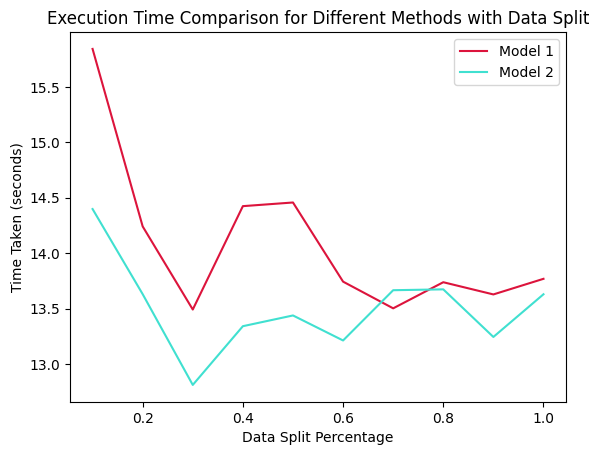

In [24]:
# Define the list of split percentages
split_percentage = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Import the necessary plotting library
import matplotlib.pyplot as plt

# Create a line plot for M1 execution times
plt.plot(split_percentage, M1_times, label="Model 1", color="crimson")

# Create a line plot for M2 execution times
plt.plot(split_percentage, M2_times, label="Model 2", color="turquoise")

# Set the label for the x-axis
plt.xlabel("Data Split Percentage")

# Set the label for the y-axis
plt.ylabel("Time Taken (seconds)")

# Set the title of the plot
plt.title("Execution Time Comparison for Different Methods with Data Split")

# Display a legend to distinguish between M1 and M2
plt.legend()

# Display the plot
plt.show()